In [21]:
from coffea import processor
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoEventsFactory , NanoAODSchema
import mplhep as hep
import hist 
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
plt.style.use(hep.style.CMS)

In [9]:
class ZProcessor(processor.ProcessorABC):
    def __init__ (self) :
        pass
    
    def process(self, events):
        #dataset = events.metadata["Datasets"]
        # Takes events as Nanoevents object with NanoAODSchema v6
        #Define your cuts
        selection = PackedSelection()
        selection.add("pt_greater_25", ak.all(events.Electron.pt > 25 , axis = 1) )
        selection.add("noMuon", ak.num(events.Muon) == 0 )
        selection.add("TightID", ak.all ( events.Electron.cutBased == 4 , axis = 1))
        selection.add("twoElectrons", ak.num(events.Electron) == 2)
        selection.add("OppositeCharge", ak.sum(events.Electron.charge , axis=1 ) == 0)

        #Apply the cuts
        good_events_OppSign_cut = selection.require(pt_greater_25 = True ,
                                        noMuon = True ,
                                        TightID = True ,
                                        twoElectrons = True ,
                                        OppositeCharge = True ,
                                       )
        good_events_SameSign_cut = selection.require(pt_greater_25 = True ,
                                        noMuon = True ,
                                        TightID = True ,
                                        twoElectrons = True ,
                                        OppositeCharge = False ,
                                       )
        good_events_OppSign = events[good_events_OppSign_cut]
        good_events_SameSign = events[good_events_SameSign_cut]

        #Construct DiElectron object and find invariant mass
        DiElectronMassOppSign = ( good_events_OppSign.Electron[:, 0] + good_events_OppSign.Electron[:, 1] ).mass
        DiElectronMassSameSign = ( good_events_SameSign.Electron[:, 0] + good_events_SameSign.Electron[:, 1] ).mass        
        #Create a histogram and fill with the masses
        hmass = (
            hist.Hist.new
            .StrCat(["OppSign","SameSign"], name="Sign")
            .Reg(100, 25. , 225. , name="mass" , label="$M_{ll}$ [GeV]")
            .Double()
        )

        hmass.fill(Sign = "OppSign" , mass = DiElectronMassOppSign)
        hmass.fill(Sign = "SameSign" , mass =DiElectronMassSameSign)

        #Return the output dictionary
        dataset = "SingleElectron"
        output = {
            dataset : {
                "Entries" : len(events) ,
                "hmass" : hmass
            }
        }
        return output
        
    def postprocess(self, accumulator):
        pass

In [14]:
fileset = {
    "Datasets": ["data/3BF5BC57-5D24-1C4D-B277-7B0BAA5DF3C7.root"] 
}
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None , workers = 4),
    schema=NanoAODSchema,
    maxchunks=4,
)
out = futures_run(
    fileset,
    "Events",
    processor_instance=ZProcessor()
)

print(out)

Output()

{'SingleElectron': {'Entries': 297347, 'hmass': Hist(
  StrCategory(['OppSign', 'SameSign'], name='Sign'),
  Regular(100, 25, 225, name='mass', label='$M_{ll}$ [GeV]'),
  storage=Double()) # Sum: 7391.0 (7423.0 with flow)}}


Number of Events Processed :  297347


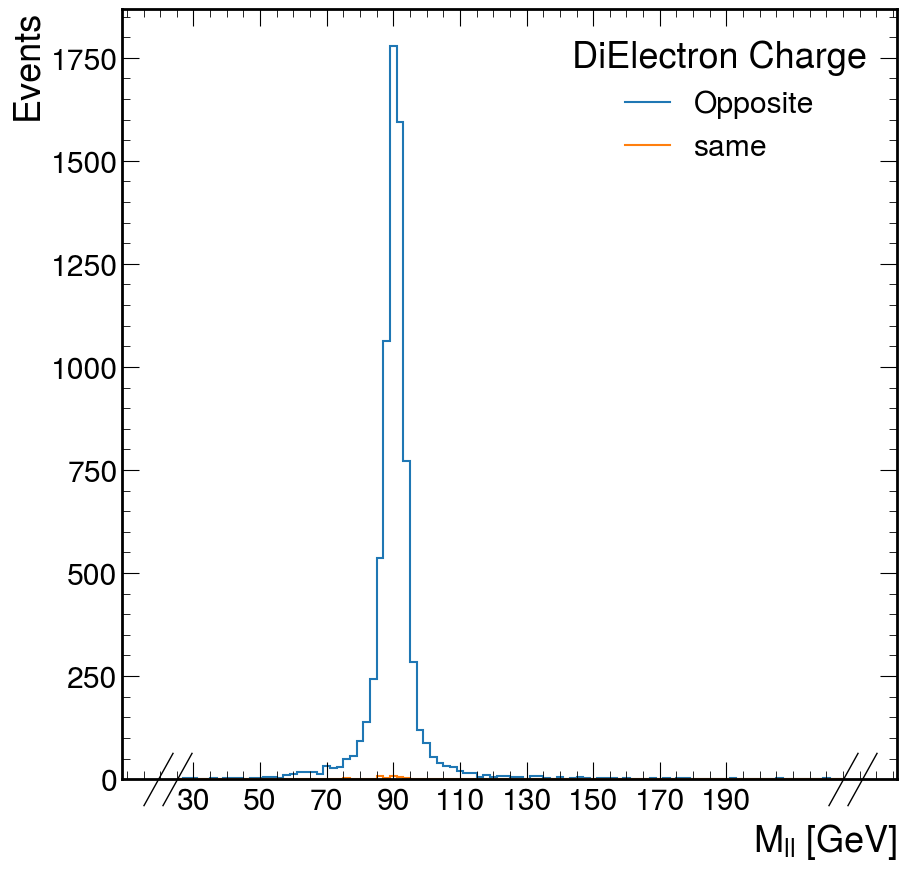

In [24]:
print("Number of Events Processed : " , out["SingleElectron"]["Entries"] )
fig , ax = plt.subplots()
out["SingleElectron"]["hmass"]["OppSign",:].plot1d(label="Opposite", ax=ax) 
out["SingleElectron"]["hmass"]["SameSign",:].plot1d(label="same", ax=ax) 
plt.xticks(np.arange(30,210,20))
plt.ylabel("Events")
#plt.yscale("log")
ax.legend(title = "DiElectron Charge")
plt.savefig("PlotCoffeaZ.png", dpi = 300)